# Imports

In [1]:
import pandas as pd
import numpy as np
import sys
import os
import csv

import scipy.stats as stats

from scipy.stats import beta
from scipy.special import gamma as gammaf

from sklearn import svm
from sklearn.metrics import roc_curve, auc, plot_roc_curve
from sklearn.model_selection import train_test_split

import matplotlib as mpl
from matplotlib import pyplot as plt

#aesthetics for plots:
font = {'family' : 'arial',
        'size'   : 18}
mpl.rc('font', **font)

%matplotlib inline

In [2]:
# to load in dictionary of EpiClass tables for each of the 10 sample set runs

def saver(dictex):
    for key, val in dictex.items():
        val.to_csv("epiclass_table_{}.csv".format(str(key)))

    with open("epiclass_runDict_keys.txt", "w") as f: #saving keys to file
        f.write(str(list(dictex.keys())))

def loader():
    """Reading data from keys"""
    with open("epiclass_runDict_keys.txt", "r") as f:
        keys = eval(f.read())

    dictex = {}    
    for key in keys:
        dictex[key] = pd.read_csv("epiclass_table_{}.csv".format(str(key)))

    return dictex

# saver(runDict)
# runDict = loader()

# Overview

Notebook detailing the generation of Figure 5 and Supplementary Table S3

EpiClass versus CancerDetector using WGBS liver and normal plasma samples from EGAS00001000566 and EGAD00001004317.

Marker regions (previously identified as liver cancer markers in CancerDetector study

# Step 1: Define Marker Regions

## ZNF154

**Use marker regions that have been prevously identified in the original CancerDetector study**

+ ZNF154
    - From CancerDetector Supplementary Table S2: ```40268	chr19:58220195-58220937``` (742bp) (hg19) overlaps the DREAMing targeted ZNF154 region.

## Identify Additional Marker Regions

**Find top 3 hypermethylated loci in LIHC to use as additional markers to test**

Identify as probes from BMIQ normalized LIHC 450K methylation array data from TCGA. Collect the overlapping CancerDetector marker regions.

Requirements:
- Use the matched tumor-normal sample pairs in LIHC
- Hypermethylated in LIHC relative to normal controls
- beta values < 0.2 in controls
- ignore probes that overlap SNPs
- Filter by greatest positive median difference of (tumors - controls) beta values

In [3]:
# CancerDetector Table S2 with marker regions:
cancerDetectorMarkers = pd.read_csv('cancerDetectorMarkerRegions.csv', index_col=0)

In [4]:
# 450K manifest file with probe coordinates (a relatively large file to host remotely)
# probeInfoRaw = pd.read_table('probe_450K_mapinfo_PQ.txt')

# selected regions of probe manifest file:
probeInfoRaw =pd.read_csv("top3markersProbeManifest.csv", index_col=0)

**Get all probes in top region, but remove those that correspond to SNPs**

In [5]:
probesInMarker6263 = probeInfoRaw[(probeInfoRaw['CHR'] == 2) & (
    probeInfoRaw['MAPINFO'] > 208989109.0) & (probeInfoRaw['MAPINFO'] < 208989679.0)]

In [6]:
# probe cg10823322 is SNP
Marker6263probeIDs = probesInMarker6263[probesInMarker6263['IlmnID'] != 'cg10823322' ]['IlmnID'].values

In [7]:
probesInMarker5594 = probeInfoRaw[(probeInfoRaw['CHR'] == 2) & (
    probeInfoRaw['MAPINFO'] > 127782982.0) & (probeInfoRaw['MAPINFO'] < 127783470.0)]

In [8]:
# probe cg12632573 is SNP
Marker5594probeIDs = probesInMarker5594[probesInMarker5594['IlmnID'] != 'cg12632573' ]['IlmnID'].values

In [9]:
Marker29305probeIDs = probeInfoRaw[(probeInfoRaw['CHR'] == 13) & (
    probeInfoRaw['MAPINFO'] > 107187077.0) & (probeInfoRaw['MAPINFO'] < 107187512.0)]['IlmnID'].values

**Beta values of all non-SNP probes in top 3 selected marker regions**

In [10]:
top3markerProbes = pd.read_table('BMIQ_LIHC_top3markerProbes.txt', index_col=0)
top3markerProbes

,TCGA.BC.A10Q.01,TCGA.BC.A10R.01,TCGA.BC.A10S.01,TCGA.BC.A10T.01,TCGA.BC.A10U.01,TCGA.BC.A10W.01,TCGA.BC.A10X.01,TCGA.BC.A10Y.01,TCGA.BC.A10Z.01,TCGA.BC.A110.01,...,TCGA.G3.A25W.11,TCGA.G3.A25X.11,tumor_median,tumor_std,normal_median,normal_std,normal_max,median_diff,chr,coord
cg12073779,0.974455,0.838617,0.901963,0.768782,0.074145,0.897122,0.646167,0.942757,0.696955,0.607952,...,0.685856,0.592129,0.786517,0.245031,0.692014,0.087703,0.953090,0.094503,chr2,208989469.0
cg17916432,0.762741,0.678842,0.591723,0.660340,0.279492,0.696145,0.492397,0.657082,0.685564,0.439019,...,0.485416,0.455460,0.636660,0.129651,0.491828,0.031056,0.570639,0.144832,chr2,208989209.0
cg22399133,0.921646,0.860264,0.754477,0.773696,0.220705,0.857097,0.199261,0.211506,0.955603,0.101475,...,0.102159,0.137390,0.786568,0.276648,0.084370,0.030881,0.198478,0.702199,chr2,208989248.0
cg23405212,0.528084,0.569283,0.462367,0.083214,0.029903,0.767586,0.155684,0.504160,0.266911,0.061546,...,0.177677,0.128007,0.483264,0.279821,0.116958,0.051197,0.325005,0.366306,chr2,208989382.0
cg25429719,0.808312,0.586574,0.413016,0.325805,0.285948,0.838523,0.329415,0.457389,0.580132,0.182499,...,0.303629,0.239423,0.564165,0.228715,0.235799,0.065638,0.405954,0.328366,chr2,208989324.0
cg22830113,0.877915,0.669089,0.058318,0.830804,0.735158,0.404975,0.070561,0.699801,0.025318,0.029740,...,0.042436,0.023322,0.685087,0.318280,0.039406,0.028917,0.162122,0.645680,chr2,127783168.0
cg06784108,0.031525,0.066620,0.570767,0.650628,0.032803,0.743410,0.056936,0.944594,0.074857,0.081878,...,0.097973,0.032973,0.412494,0.282677,0.069550,0.029236,0.161683,0.342944,chr13,107187232.0
cg11173146,0.033709,0.034197,0.679410,0.828508,0.088801,0.478818,0.031084,0.630992,0.021117,0.251691,...,0.085524,0.018815,0.612875,0.310942,0.035103,0.030756,0.146720,0.577772,chr13,107187412.0
cg27226949,0.057001,0.496149,0.621773,0.584789,0.046910,0.670267,0.088659,0.200878,0.533813,0.212675,...,0.121446,0.057328,0.514282,0.258044,0.105884,0.099681,0.726864,0.408398,chr13,107187177.0


In [11]:
tumorBarcodes = [i for i in top3markerProbes.columns if '.01' in i]
normalBarcodes = [i for i in top3markerProbes.columns if '.11' in i]

# Step 2: Define Training and Test Sample cohorts

In [12]:
def generateSplits(data, random_state, test_size):
    
    y = np.zeros(len(data))
    
    _train, _test, y_train, y_test = train_test_split(data, y, test_size=test_size, random_state=random_state)
    
    return _train, _test

In [13]:
# master WGBS sample list from CUHK and UCLA groups:
sampleMeta = pd.read_csv('sample_master_list.csv')

In [14]:
WGBScontrols = sampleMeta[ (sampleMeta['patient type'] == 'control') & (sampleMeta['tissue'] == 'plasma') ]
Controls = WGBScontrols['sample'].values.tolist()

In [15]:
WGBScases = sampleMeta[ (sampleMeta['patient type'] == 'HCC') & (sampleMeta['tissue'] == 'plasma') ]
Cases = WGBScases['sample'].values.tolist()

In [16]:
numRuns = 10

runNames = []
for run in np.arange(1, numRuns +1):
    name = 'Run {}'.format(run)
    runNames.append(name)

trials = pd.DataFrame(columns=['Control Training', 'Control Test', 'Case Training', 'Case Test'], index=runNames)

for run in np.arange(numRuns):
    randomState = run + 1
    Control_train, Control_test = generateSplits(Controls, randomState, 0.50)
    Case_train, Case_test = generateSplits(Cases, randomState, 0.50)
    
    controlTrainSet = " ".join(Control_train)
    controlTestSet = " ".join(Control_test)
    caseTrainSet = " ".join(Case_train)
    caseTestSet = " ".join(Case_test)
    
    trials.loc[runNames[run], 'Control Training'] = controlTrainSet
    trials.loc[runNames[run], 'Control Test'] = controlTestSet
    trials.loc[runNames[run], 'Case Training'] = caseTrainSet
    trials.loc[runNames[run], 'Case Test'] = caseTestSet

# Step 3: EpiClass Analysis

## Generate normalized read counts at each region of interest

1. Bismark aligned BAM files of WGBS samples

    - TrimGalore-0.6.0

    - Bismark Version: v0.20.0

    - ```filter_non_conversion``` v0.20.0

    - ```deduplicate_bismark``` v0.20.0

    - ```bismark_methylation_extractor --comprehensive``` v0.20.0
    

2. Create and index [bgzip, tabix] bedGraph file for C-in-CpG context (readCpGcoverageFiles)
    
    - Obtain coverage information for the number of U and M CpGs covered by reads across genome.
    - **To be used as input into CancerDetector**

    - ```bismark2bedGraph```


3. Get reads in regions of interest (ZNF154 plus the 3 selected markers) for each sample $bam file

    - ```samtools view -b -h $bam $regionInterval_1 $regionInterval_2 $regionInterval_3 $regionInterval_4 > $out```
    
    - Have region interval extend slightly beyond the region to ensure all potentially overlapping reads are captured


4. EpiClass version 2.2.5
    - Generate READtoMD.DT files for each region using EpiClass.
    - ```epiclass READtoMD -i $DirWithBams --intervals $regionInterval --overlap 1.0 --fileTag markerName```
    - These tables have the number of U and M CpGs in each read for each sample in the given region. Used to compute read counts for each methylation density cutoffs and thus find the optimal methylation density cutoff for training cohort.
    - **Also used to generate the methylation patterns for each read to be used as input for CancerDetector.**
    
    
5. Get lists of samples in each set

    - ```controlTrainingSets.txt```
    - ```caseTrainingSets.txt```
    - ```controlTestSets.txt```
    - ```caseTestSets.txt```

```
for index, row in trials.iterrows():
     print(index)
     print("Control Training:")
     print(row['Case Test'])
     print(" ")
     print("Case Training:")
     print(row['Case Training'])
     print(" ")
```


lociFile.txt:

```
    ZNF154 chr19:58220195-58220937 READtoMDtables/READtoMD.DT.markerZNF154.csv
    Marker6263 chr2:208989109-208989679 READtoMDtables/READtoMD.DT.marker6263.csv
    Marker5594 chr2:127782982-127783470 READtoMDtables/READtoMD.DT.marker5594.csv
    Marker29305 chr13:107187077-107187512 READtoMDtables/READtoMD.DT.marker29305.csv
```

6. ```runEpiClass.sh```

    - run epiclass on training set and get optimal MD cutoff
    - run epiclass on testing set and get read count values for samples at the optimal MD cutoff

```
#!/bin/bash

controlTrainSets="controlTrainingSets.txt"
caseTrainSets="caseTrainingSets.txt"

controlTestSets="controlTestSets.txt"
caseTestSets="caseTestSets.txt"

# make arrays to store sample set lists from each of the above files
# where each line is a set of samples for a given run
IFS=$'\n' read -d '' -r -a controlsTrain < $controlTrainSets
IFS=$'\n' read -d '' -r -a casesTrain < $caseTrainSets

IFS=$'\n' read -d '' -r -a controlsTest < $controlTestSets
IFS=$'\n' read -d '' -r -a casesTest < $caseTestSets

lociFile="_loci.txt"
IFS=$'\n' read -d '' -r -a loci < $lociFile
numLoci=$((${#loci[@]}-1))

fractions="WGBS_sample_fractions.csv"


for i in {0..9} #10 runs, corresponds to number of Training/Test sets
do

	runNum=$(($i+1))

	echo "EpiClass Run "$runNum

	controlsSamplesTraining=${controlsTrain[i]}
	caseSamplesTraining=${casesTrain[i]}

	controlsSamplesTest=${controlsTest[i]}
	caseSamplesTest=${casesTest[i]}

	runTrainingDir="epiclass_MultiLoci_runs/Run_"$runNum"/training/"
	runTestingDir="epiclass_MultiLoci_runs/Run_"$runNum"/testing/"

	# for each run, perform epiclass on training and testing sets for each locus
	for l in $(seq 0 $numLoci)
	do

		locus=$(echo ${loci[l]} | cut -d' ' -f1)
		interval=$(echo ${loci[l]} | cut -d' ' -f2)
		locusREADtoDTpath=$(echo ${loci[l]} | cut -d' ' -f3) #READtoDT file generated based on a given locus genomic interval

		echo $locus
		
		locusTrainDirOut=$runTrainingDir$locus

		fileTagTrain=$locus"_Run_"$runNum"_training"
		locusTrainLogFile=$locusTrainDirOut"/"$fileTagTrain".log"

		mkdir -p $locusTrainDirOut

		echo "EpiClass training set..."

		epiclass MDBC -i $locusREADtoDTpath -a $caseSamplesTraining -b $controlsSamplesTraining \
		--fractions $fractions --ignoreEFsummary --optimalMDreadcounts \
		--fileTag $fileTagTrain -o $locusTrainDirOut > $locusTrainLogFile

		# get the optimal MD cutoff for read counts, obtained from the log file
		while read line; do
			if [[ "$line" == *"Optimal MD cutoff (read counts)"* ]]; then
	  			md=$(echo $line | cut -d'=' -f 2 | cut -d' ' -f 2)
			fi
		done < $locusTrainLogFile


		echo "MDBC test set with MD = "$md

		locusTestDirOut=$runTestingDir$locus

		fileTagTest=$locus"_Run_"$runNum"_testing"
		locusTestLogFile=$locusTestDirOut"/"$fileTagTest".log"

		mkdir -p $locusTestDirOut

		epiclass MDBC -i $locusREADtoDTpath -a $caseSamplesTest -b $controlsSamplesTest \
		--fractions $fractions --ignoreCountsummary --ignoreEFsummary --sampleValsAtMD $md \
		--fileTag $fileTagTest -o $locusTestDirOut > $locusTestLogFile

		# get training sample count values for optimal MD
		epiclass MDBC -i $locusREADtoDTpath -a $caseSamplesTraining -b $controlsSamplesTraining \
		--fractions $fractions --ignoreCountsummary --ignoreEFsummary --sampleValsAtMD $md \
		--fileTag $fileTagTrain -o $locusTrainDirOut

	done

done
```



The structure of the output directory:

```
.
├── Run_1
│   ├── Cases
│   └── Controls
├── Run_10
│   ├── Cases
│   └── Controls
├── Run_2
│   ├── Cases
│   └── Controls
├── Run_3
│   ├── Cases
│   └── Controls
├── Run_4
│   ├── Cases
│   └── Controls
├── Run_5
│   ├── Cases
│   └── Controls
├── Run_6
│   ├── Cases
│   └── Controls
├── Run_7
│   ├── Cases
│   └── Controls
├── Run_8
│   ├── Cases
│   └── Controls
└── Run_9
    ├── Cases
    └── Controls
```

And looking for the ```*_MD-COUNT-VALS.csv``` files, which have the values

## Analyse EpiClass outputs and generate ROC curves

For each run, generate table for samples that have the normalized methylated read counts (for optimal MD cutoff) for each locus as well as the set the sample belongs to for each run.

**runDict tables from EpiClass Analysis already generated. Load with ```loader()```; see below**

In [17]:
# For combining multiple markers, use a linear model based on the normalized read counts for each region.

random_state = np.random.RandomState(0)
classifier = svm.SVC(kernel='linear', probability=True,
                     random_state=random_state)

In [18]:
# load epiclass tables of read counts for each locus:
runDict = loader()

### ZNF154

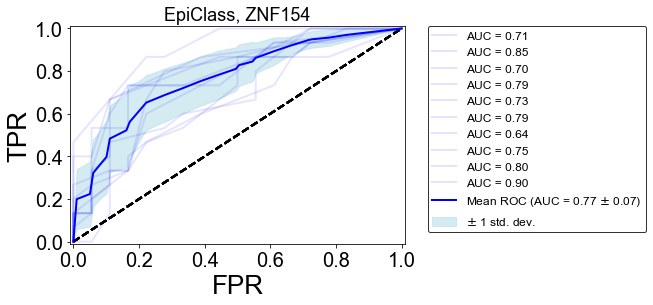

In [19]:
mean_fpr = np.linspace(0, 1, 100)
epiclass_aucs_ZNF = []
epiclass_tprs = []

fig, ax = plt.subplots()

sortedRunDict = dict(sorted(runDict.items()))

for run, vals in sortedRunDict.items():
    
    values = vals[vals['set_type'] == 'testing']['ZNF154']
    labels = vals[vals['set_type'] == 'testing']['set']

    fpr, tpr, thresholds = roc_curve(labels, values)
    roc_auc = auc(fpr, tpr)

#     optimal_idx = np.argmax(tpr - fpr)
#     optimal_threshold = thresholds[optimal_idx]
#     sensitivity = tpr[optimal_idx]
#     specificity = 1 - fpr[optimal_idx]

    epiclass_aucs_ZNF.append(roc_auc)

    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    epiclass_tprs.append(interp_tpr)

    lw = 2
    plt.plot(fpr, tpr, color='blue', lw=lw,
             label='AUC = %0.2f' % roc_auc, alpha=0.1)
    plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.00])
    plt.ylim([0.0, 1.00])
    plt.xlabel('FPR', fontsize=26)
    plt.ylabel('TPR', fontsize=26)
    plt.xticks(np.arange(0, 1.1, .2), [str(round(i, 2))
                                       for i in np.arange(0, 1.1, .2)], fontsize=20)
    plt.yticks(np.arange(0, 1.1, .2), [str(round(i, 2))
                                       for i in np.arange(0, 1.1, .2)], fontsize=20)

mean_tpr = np.mean(epiclass_tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(epiclass_aucs_ZNF)


ax.plot(mean_fpr, mean_tpr, color='blue',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2)

std_tpr = np.std(epiclass_tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='lightblue', alpha=.5,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])

plt.title('EpiClass, ZNF154', fontsize=18)

plt.legend(bbox_to_anchor=(1.05, 1.03),
               loc='upper left', fontsize=12, edgecolor='k')

plt.show()
# plt.savefig('EpiClass_ZNF_10runs_ROC_LiverWGBS.png', bbox_inches='tight', pad_inches=0.5, dpi=600)

### Top 3 markers

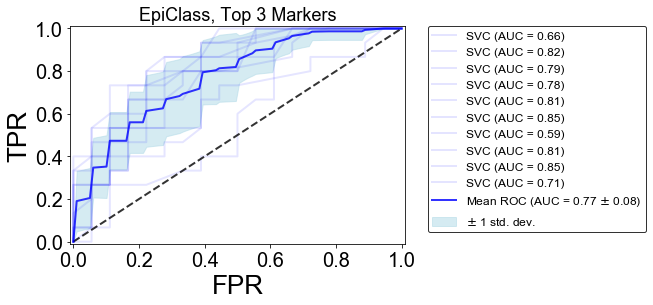

In [20]:
tprs = []
epiclass_aucs_3markers = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()

sortedRunDict = dict(sorted(runDict.items()))

for run, vals in sortedRunDict.items():
    
#     ['Marker6263', 'Marker5594', 'Marker29305', 'ZNF154']
    trainVals = vals[vals['set_type'] == 'training'][['Marker6263', 'Marker5594', 'Marker29305']]
    trainLabels = vals[vals['set_type'] == 'training']['set']
    
    testVals = vals[vals['set_type'] == 'testing'][['Marker6263', 'Marker5594', 'Marker29305']]
    testLabels = vals[vals['set_type'] == 'testing']['set']
    
    classifier.fit(trainVals, trainLabels)
    viz = plot_roc_curve(classifier, testVals, testLabels,
#                          label='AUC = {}'.format(round(viz.roc_auc, 2)), #name='ROC {}'.format(run),
                         alpha=0.1, lw=2, ax=ax, color='b')
    ax.set_label('AUC = {}'.format(round(viz.roc_auc, 2)))
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    epiclass_aucs_3markers.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(epiclass_aucs_3markers)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='lightblue', alpha=.5,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.01, 1.01], ylim=[-0.01, 1.01],
       title="EpiClass")

plt.xlabel('FPR', fontsize=26)
plt.ylabel('TPR', fontsize=26)
plt.xticks(np.arange(0, 1.1, .2), [str(round(i, 2))
                                   for i in np.arange(0, 1.1, .2)], fontsize=20)
plt.yticks(np.arange(0, 1.1, .2), [str(round(i, 2))
                                   for i in np.arange(0, 1.1, .2)], fontsize=20)

plt.legend(bbox_to_anchor=(1.05, 1.03),
               loc='upper left', fontsize=12, edgecolor='k')

plt.title('EpiClass, Top 3 Markers', fontsize=18)

plt.show()
# plt.savefig('top3_EpiClass_10runs_ROC_LiverWGBS.png', bbox_inches='tight', pad_inches=0.5, dpi=600)

### Top 3 markers + ZNF154

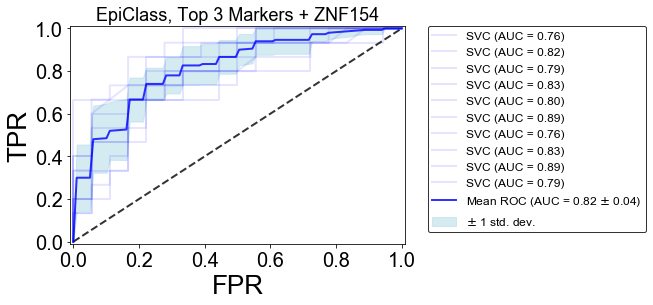

In [21]:
tprs = []
epiclass_aucs_3plusZNF = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()

sortedRunDict = dict(sorted(runDict.items()))

for run, vals in sortedRunDict.items():
    
#     ['Marker6263', 'Marker5594', 'Marker29305', 'ZNF154']
    trainVals = vals[vals['set_type'] == 'training'][['Marker6263', 'Marker5594', 'Marker29305', 'ZNF154']]
    trainLabels = vals[vals['set_type'] == 'training']['set']
    
    testVals = vals[vals['set_type'] == 'testing'][['Marker6263', 'Marker5594', 'Marker29305', 'ZNF154']]
    testLabels = vals[vals['set_type'] == 'testing']['set']
    
    classifier.fit(trainVals, trainLabels)
    viz = plot_roc_curve(classifier, testVals, testLabels,
#                          label='AUC = {}'.format(round(viz.roc_auc, 2)), #name='ROC {}'.format(run),
                         alpha=0.1, lw=2, ax=ax, color='b')
    ax.set_label('AUC = {}'.format(round(viz.roc_auc, 2)))
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    epiclass_aucs_3plusZNF.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(epiclass_aucs_3plusZNF)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='lightblue', alpha=.5,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.01, 1.01], ylim=[-0.01, 1.01],
       title="EpiClass")

plt.xlabel('FPR', fontsize=26)
plt.ylabel('TPR', fontsize=26)
plt.xticks(np.arange(0, 1.1, .2), [str(round(i, 2))
                                   for i in np.arange(0, 1.1, .2)], fontsize=20)
plt.yticks(np.arange(0, 1.1, .2), [str(round(i, 2))
                                   for i in np.arange(0, 1.1, .2)], fontsize=20)

plt.legend(bbox_to_anchor=(1.05, 1.03),
               loc='upper left', fontsize=12, edgecolor='k')

plt.title('EpiClass, Top 3 Markers + ZNF154', fontsize=18)

plt.show()
# plt.savefig('top3plusZNF_EpiClass_10runs_ROC_LiverWGBS.png', bbox_inches='tight', pad_inches=0.5, dpi=600)

# Step 4: CancerDetector Analysis

## Compute Tumor and Normal Class Shape Parameters

- Shape paramaters learnt from modeling beta distributions for each sample class (Tumors or Normals).

    - Tumor Class beta distribution is built using the beta values for the matched LIHC tumor sample 450K methylation array data .
    
    - Normal Class beta distribution is bult using beta values for matched normal LIHC sample 450K methylation array data.
        - But also from training sample set WGBS data (the methylation level based on number of meCpGs / total CpGs of reads for given region).
    
- Shape parameters learnt for each region.

...

**Comments**:

Averaging the methylation level across a given region for each sample resulted in significantly worse performance for CancerDetector.

This may be due to the fact that the resulting beta distributions were heavily weighted towards either fully methylated (betas 0.8-1.0) or unmethylated (0.0-0.2). As most reads at these regions in liquid biopsy were unmethylated, the rarity of fully methylated reads and the low likelihood of reads being assigned to the Tumor Class resulted in poor sensitivity.

However, including methylation level of all CpGs in a region expanded the Tumor Class beta distribution to also include more heterogeneous methylation. Thus it is probable that more reads were assigned to the Tumor Class and improved sensitivity.

For the subsequent comparison, the methylation level at all CpGs in a given region were considered instead of averaging.

In the context of EpiClass, drawing a simple cutoff to include heterogeneously methylated reads as signal probably explains its higher performance by boosting signal, even for a small panel of loci with low read coverage.


**The estimated sample tumor fractions using different combinations of markers based on their shape parameters have been calculated and can be found in ```*SampleTumorBurdens.txt``` files.**

**The code below shows how the beta distribution shape parameters were computed, and stored in ```Supplementary_Table_S3.txt```**

### Coverage Files

Coverage files for given marker region generated via ```bismark2bedGraph```

Then, select the coverage for a given region by:

```
$1="*.CpG.dedup.cov.bgz" # bismark2bedGraph output file for given sample
interval=chr:start-stop
sample=$(basename "$1" .bgz)
output=$sample.CancerDetectorMarkerName.txt
tabix -f $1 $interval > $output
```

Sample coverage files for each regions stored in separate directories

### Marker6263

Methylation levels at CpGs in given region for the WGBS samples:

Methylation 450K beta values  for the associated marker probes:

For each run, combine methylation levels of 450K and WGBS samples, and compute shape parameters.

### Marker5594

Methylation levels at CpGs in given region for the WGBS samples:

Methylation 450K beta values  for the associated marker probes:

For each run, combine methylation levels of 450K and WGBS samples, and compute shape parameters.

### Marker29305

Methylation levels at CpGs in given region for the WGBS samples:

Methylation 450K beta values  for the associated marker probes:

For each run, combine methylation levels of 450K and WGBS samples, and compute shape parameters.

### ZNF154

Methylation levels at CpGs in given region for the WGBS samples:

Methylation 450K beta values  for the associated marker probes:

For each run, combine methylation levels of 450K and WGBS samples, and compute shape parameters.

## Generate Marker and Sample Read Input Files

### Notes and function to make inputs

CancerDetector requires a marker input file, which has the class shape parameters for Tumor Class and the Normal Class, for each marker being considered to compute sample tumor fraction.

For each sample, it also requires a read input file, which has the methylation patterns as 0 = unmethylated and 1 = methylated for reads aligned to each marker region being considered.

**The estimated sample tumor fractions using different combinations of markers based on their shape parameters have been calculated and can be found in ```*SampleTumorBurdens.txt``` files.**

**The code below shows how the sample read and marker CancerDetector input files were made**

### ZNF154 only inputs

### Top 3 Marker inputs

### Top3 plus ZNF154 inputs

## Compute sample tumor read fraction

```runCancerDetectorMultiRuns.sh``` to iterate through input samples and estimate their tumor fraction

The output directory structure is:

```
.
├── Run_1
│   ├── Cases
│   └── Controls
├── Run_10
│   ├── Cases
│   └── Controls
├── Run_2
│   ├── Cases
│   └── Controls
├── Run_3
│   ├── Cases
│   └── Controls
├── Run_4
│   ├── Cases
│   └── Controls
├── Run_5
│   ├── Cases
│   └── Controls
├── Run_6
│   ├── Cases
│   └── Controls
├── Run_7
│   ├── Cases
│   └── Controls
├── Run_8
│   ├── Cases
│   └── Controls
└── Run_9
    ├── Cases
    └── Controls
```

And in a given folder is the ```SAMPLE.run_#.likelihood/tumor_burden``` files

In the ```.tumor_burden``` is something like this:

0.3640	0.6360

First column is estimated tumor fraction and second column is estimated normal_plasma fraction.

Build ROC curves using the estimated tumor fraction of the testing sample set cases and controls for each run.

10 runs so 10 curves.

## Generate ROC curves for CancerDetector

**The estimated sample tumor fractions using different combinations of markers based on their shape parameters have been calculated and can be found in ```*SampleTumorBurdens.txt``` files.**

**The code below shows how the estimated tumor burdens for each sample, based on the markers of interest for a given run, were obtained in the CancerDetector output directories**

**These values are stored in ```*SampleTumorBurdens.txt``` files and these are parsed to generate the CancerDetector ROC curves shown here.***

### ZNF154 only

In [35]:
ZNF154tumorBurdenTable = pd.read_csv("ZNFCancerDetectorSampleTumorBurdens.csv", index_col=0)

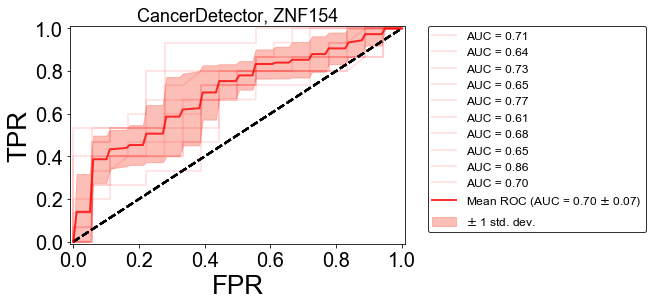

In [36]:
mean_fpr = np.linspace(0, 1, 100)
cancerdetector_aucs_ZNF154 = []
cancerdetector_tprs = []

fig, ax = plt.subplots()
for index, row in ZNF154tumorBurdenTable.iterrows():

    controlVals = [float(i) for i in row.loc[Controls].dropna().values]
    caseVals = [float(i) for i in row.loc[Cases].dropna().values]

    values = controlVals + caseVals
    labels = [0 for i in controlVals] + [1 for i in caseVals]
    fpr, tpr, thresholds = roc_curve(labels, values)
    roc_auc = auc(fpr, tpr)
    

#     optimal_idx = np.argmax(tpr - fpr)
#     optimal_threshold = thresholds[optimal_idx]
#     sensitivity = tpr[optimal_idx]
#     specificity = 1 - fpr[optimal_idx]

    cancerdetector_aucs_ZNF154.append(roc_auc)
    
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    cancerdetector_tprs.append(interp_tpr)

    lw = 2
    plt.plot(fpr, tpr, color='red', lw=lw,
             label='AUC = %0.2f' % roc_auc, alpha=0.1)
    plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.00])
    plt.ylim([0.0, 1.00])
    plt.xlabel('FPR', fontsize=26)
    plt.ylabel('TPR', fontsize=26)
    plt.xticks(np.arange(0, 1.1, .2), [str(round(i, 2))
                                       for i in np.arange(0, 1.1, .2)], fontsize=20)
    plt.yticks(np.arange(0, 1.1, .2), [str(round(i, 2))
                                       for i in np.arange(0, 1.1, .2)], fontsize=20)


mean_tpr = np.mean(cancerdetector_tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(cancerdetector_aucs_ZNF154)


ax.plot(mean_fpr, mean_tpr, color='red',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=0.8)

std_tpr = np.std(cancerdetector_tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='salmon', alpha=.5,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])

plt.legend(bbox_to_anchor=(1.05, 1.03),
               loc='upper left', fontsize=12, edgecolor='k')

plt.title('CancerDetector, ZNF154', fontsize=18)

plt.show()
# plt.savefig('CancerDetector_ZNF154_10runs_ROC_LiverWGBS.png', bbox_inches='tight', pad_inches=0.5, dpi=600)

### Top 3 markers

In [37]:
Top3tumorBurdenTable = pd.read_csv("Top3CancerDetectorSampleTumorBurdens.csv", index_col=0)

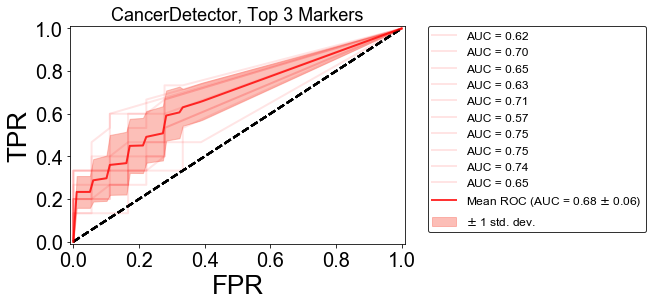

In [38]:
mean_fpr = np.linspace(0, 1, 100)
cancerdetector_aucs_top3 = []
cancerdetector_tprs = []

fig, ax = plt.subplots()
for index, row in Top3tumorBurdenTable.iterrows():

    controlVals = [float(i) for i in row.loc[Controls].dropna().values]
    caseVals = [float(i) for i in row.loc[Cases].dropna().values]

    values = controlVals + caseVals
    labels = [0 for i in controlVals] + [1 for i in caseVals]
    fpr, tpr, thresholds = roc_curve(labels, values)
    roc_auc = auc(fpr, tpr)
    

#     optimal_idx = np.argmax(tpr - fpr)
#     optimal_threshold = thresholds[optimal_idx]
#     sensitivity = tpr[optimal_idx]
#     specificity = 1 - fpr[optimal_idx]

    cancerdetector_aucs_top3.append(roc_auc)
    
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    cancerdetector_tprs.append(interp_tpr)

    lw = 2
    plt.plot(fpr, tpr, color='red', lw=lw,
             label='AUC = %0.2f' % roc_auc, alpha=0.1)
    plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.00])
    plt.ylim([0.0, 1.00])
    plt.xlabel('FPR', fontsize=26)
    plt.ylabel('TPR', fontsize=26)
    plt.xticks(np.arange(0, 1.1, .2), [str(round(i, 2))
                                       for i in np.arange(0, 1.1, .2)], fontsize=20)
    plt.yticks(np.arange(0, 1.1, .2), [str(round(i, 2))
                                       for i in np.arange(0, 1.1, .2)], fontsize=20)


mean_tpr = np.mean(cancerdetector_tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(cancerdetector_aucs_top3)


ax.plot(mean_fpr, mean_tpr, color='red',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=0.8)

std_tpr = np.std(cancerdetector_tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='salmon', alpha=.5,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])

plt.legend(bbox_to_anchor=(1.05, 1.03),
               loc='upper left', fontsize=12, edgecolor='k')

plt.title('CancerDetector, Top 3 Markers', fontsize=18)

plt.show()
# plt.savefig('CancerDetector_Top3_10runs_ROC_LiverWGBS.png', bbox_inches='tight', pad_inches=0.5, dpi=600)

### Top 3 plus ZNF154

In [39]:
Top3plusZNF154tumorBurdenTable = pd.read_csv("Top3plusZNF154CancerDetectorSampleTumorBurdens.csv", index_col=0)

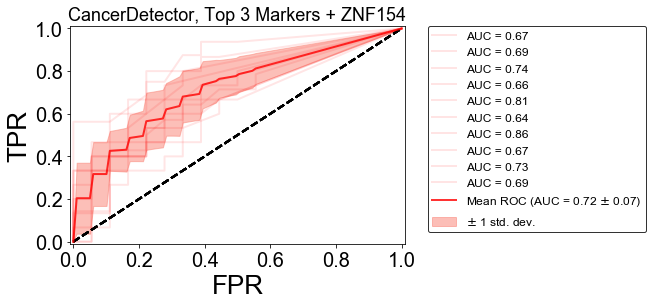

In [40]:
mean_fpr = np.linspace(0, 1, 100)
cancerdetector_aucs_top3plusZNF154 = []
cancerdetector_tprs = []

fig, ax = plt.subplots()
for index, row in Top3plusZNF154tumorBurdenTable.iterrows():

    controlVals = [float(i) for i in row.loc[Controls].dropna().values]
    caseVals = [float(i) for i in row.loc[Cases].dropna().values]

    values = controlVals + caseVals
    labels = [0 for i in controlVals] + [1 for i in caseVals]
    fpr, tpr, thresholds = roc_curve(labels, values)
    roc_auc = auc(fpr, tpr)
    

#     optimal_idx = np.argmax(tpr - fpr)
#     optimal_threshold = thresholds[optimal_idx]
#     sensitivity = tpr[optimal_idx]
#     specificity = 1 - fpr[optimal_idx]

    cancerdetector_aucs_top3plusZNF154.append(roc_auc)
    
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    cancerdetector_tprs.append(interp_tpr)

    lw = 2
    plt.plot(fpr, tpr, color='red', lw=lw,
             label='AUC = %0.2f' % roc_auc, alpha=0.1)
    plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.00])
    plt.ylim([0.0, 1.00])
    plt.xlabel('FPR', fontsize=26)
    plt.ylabel('TPR', fontsize=26)
    plt.xticks(np.arange(0, 1.1, .2), [str(round(i, 2))
                                       for i in np.arange(0, 1.1, .2)], fontsize=20)
    plt.yticks(np.arange(0, 1.1, .2), [str(round(i, 2))
                                       for i in np.arange(0, 1.1, .2)], fontsize=20)


mean_tpr = np.mean(cancerdetector_tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(cancerdetector_aucs_top3plusZNF154)


ax.plot(mean_fpr, mean_tpr, color='red',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=0.8)

std_tpr = np.std(cancerdetector_tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='salmon', alpha=.5,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])

plt.title('CancerDetector, Top 3 Markers + ZNF154', fontsize=18)

plt.legend(bbox_to_anchor=(1.05, 1.03),
               loc='upper left', fontsize=12, edgecolor='k')

plt.show()
# plt.savefig('CancerDetector_Top3plusZNF154_10runs_ROC_LiverWGBS.png', bbox_inches='tight', pad_inches=0.5, dpi=600)

# Statistical comparisons between EpiClass and CancerDetector

In [41]:
# CancerDetector vs EpiClass, ZNF154
s, p = stats.ranksums(cancerdetector_aucs_ZNF154, epiclass_aucs_ZNF)
p

0.05878172135535886

In [42]:
# CancerDetector vs EpiClass, Top 3 plus ZNF154
s, p = stats.ranksums(cancerdetector_aucs_top3, epiclass_aucs_3markers)
p

0.012611144099313947

In [43]:
# CancerDetector vs EpiClass, Top 3 plus ZNF154
s, p = stats.ranksums(cancerdetector_aucs_top3plusZNF154, epiclass_aucs_3plusZNF)
p

0.005158957570721309

# Table with training and test sample splits, shape parameters, and epiclass cutoffs

The ```runEpiClass.sh``` output directories were parsed to find the optimal MD cutoffs used for each run for a given marker and these were added to the ```trials``` table in this notebook and saved as ```Supplemental_Table_S3.txt```.

In [44]:
trials['epiclass_ZNF154'] = [np.nan] * 10
trials['epiclass_Marker6263'] = [np.nan] * 10
trials['epiclass_Marker5594'] = [np.nan] * 10
trials['epiclass_Marker29305'] = [np.nan] * 10

for path, subdirs, files in os.walk('epiclass_MultiLoci_runs/'):
    for f in files:
        if "MD-COUNTS_VALS.csv" in f:
            run = " ".join(path.split("/")[-3].split('_'))
            trainORtest = path.split("/")[-2]
            locus = 'epiclass_' + path.split("/")[-1]
            md = '0.' + str(f.split('.')[4].split('_MD')[0])
            
            if trainORtest == 'testing':
                
                trials.loc[run, locus] = md
            
trials.to_csv('Supplemental_Table_S3.txt', sep='\t')          